In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt

In [21]:
def gauss(x, b=0, c=1):
    return np.exp(-(x-b)**2/(2*c**2))

def gauss_kx(x, kx, b=0, c=1):
    return gauss(x, b, c) * np.exp(1j * kx * x)

def get_BC_kx(x_0, x_max, x_step, kx, beam_center=0, waist=1):
    BC = [gauss_kx(x, kx, beam_center, waist) for x in np.arange(x_0, x_max, x_step)]
    return np.array(BC)

In [4]:
# n profile
def n_vec_sqr(x, coef=265914.79484724946):
    if np.abs(x) <= 10**(-6):
        val = 1 + (coef * x)**4
    else:
        val = 1.005
    return val**2 - 1

def dEdz_vec(E, x, k, n_sqr_minus, ddx):
    V_eff = k * (n_sqr_minus) / 2
    return (((-V_eff * E) - ddx/(2*k)) / 1j)

def RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_sqr):
    # list of zvals
    z_list = np.arange(z_0, z_max, z_step)
    
    # list of xvals
    x_list = np.arange(x_0, x_max, x_step)
        
    # grid of E vals starts as just the boundary conditions
    E_grid = [BC]
    
    # loop over z's
    for i in range(int((z_max - z_0) / z_step)):
        # 1st derivative
        der_1 = np.gradient(E_grid[i], x_step)
        
        # 2nd derivative
        der_vals = np.gradient(der_1, x_step)
        
        k1_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals)
        k2_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals + 0.5 * k1_vec)
        k3_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals + 0.5 * k2_vec)
        k4_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals + k3_vec)
        
        E_grid.append(E_grid[i] + k1_vec/6 + k2_vec/3 + k3_vec/3 + k4_vec/6)
        # print % done
        if i % 10 == 0:
            frac = i/len(z_list)
            print(str(frac*100)[:4]+" %", end = "\r")
    # 64 bit floats instead of 128 to help memory usage
    return np.array(E_grid, dtype=np.complex64)

In [18]:
# physical params
lam = 200 * 10**(-9) # meters
k = 2*np.pi/lam

# spatial params unit (m)
unit = 10**(-6)

# beam params
beam_center = -10 * unit
waist = unit / 2

# spatial params
x_step = 10**(-7)
x_0 = -15 * unit
x_max = 15 * unit

z_step = 10**(-10)
z_0 = 0
z_max = 50 * unit

angle = 1 / 20
kx = np.sin(angle) * k
kz = np.cos(angle) * k

x_list = np.arange(x_0, x_max, x_step)
n_list = np.array([n_vec_sqr(x) for x in x_list])

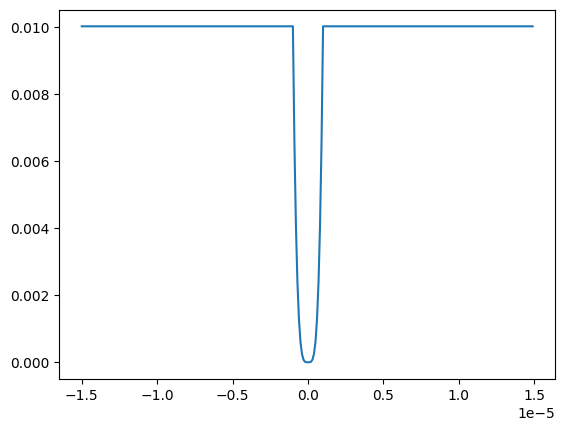

In [19]:
plt.plot(x_list, n_list)

In [20]:
# get start time
start_time = time.time()

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_list)

# show how long it took
print(str(time.time()-start_time)[:5], "s")

NameError: name 'gauss' is not defined